In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import model_from_json

In [2]:
def iou_metric(y_true, y_pred):
    # Ensure they are binary
    y_pred = np.round(y_pred)
    
    intersection = np.sum(np.abs(y_true * y_pred))
    union = np.sum(np.abs(y_true) + np.abs(y_pred)) - intersection
    iou = intersection / (union + 1e-7)  # Add epsilon to avoid division by zero
    return iou

def dice_coefficient(y_true, y_pred):
    # Ensure they are binary
    y_pred = np.round(y_pred)
    
    intersection = np.sum(np.abs(y_true * y_pred))
    dice = (2. * intersection) / (np.sum(np.abs(y_true)) + np.sum(np.abs(y_pred)) + 1e-7)  # Add epsilon to avoid division by zero
    return dice

# mAP metric
def mAP_metric(y_true, y_pred):
    # Ensure they are binary
    y_pred = np.round(y_pred)
    
    # Compute the confusion matrix
    TP = np.sum(y_true * y_pred)
    FP = np.sum(y_pred) - TP
    FN = np.sum(y_true) - TP
    TN = np.sum((1 - y_true) * (1 - y_pred))
    
    # Compute precision and recall
    precision = TP / (TP + FP + 1e-7)  # Add epsilon to avoid division by zero
    recall = TP / (TP + FN + 1e-7)  # Add epsilon to avoid division by zero
    
    return precision, recall

# Dice Loss function
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / denominator

# Combined BCE and Dice Loss
def combined_bce_dice_loss(y_true, y_pred):
    bce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce_loss + d_loss

In [3]:
# Load the model architecture and weights
with open('../models_segmentation/ODOC.json', 'r') as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights('../models_segmentation/ODOC.weights.h5')

model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy', iou_metric, dice_coefficient])

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-12-08 20:43:34.492138: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-08 20:43:34.492592: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Test on REFUGE

In [4]:
# Main function to load data from train and test directories
def load_dataset_refuge(train_dir, val_dir, test_dir, image_size):
    all_images = []
    all_masks = []
    
    train_img_dir = os.path.join(train_dir, 'Images')
    train_mask_dir = os.path.join(train_dir, 'gts')
    
    val_img_dir = os.path.join(val_dir, 'Images')
    val_mask_dir = os.path.join(val_dir, 'gts')
    
    test_img_dir = os.path.join(test_dir, 'Images')
    test_mask_dir = os.path.join(test_dir, 'gts')
    
    for img_path in tqdm(os.listdir(train_img_dir)):
        basename = img_path.split('.')[0]
        img_path = os.path.join(train_img_dir, img_path)
        mask_path = os.path.join(train_mask_dir, basename + '.bmp')
        img = load_img(img_path, target_size=image_size)
        mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                
        img_array = img_to_array(img) / 255.0
        mask_array = img_to_array(mask) / 255.0
        
        all_images.append(img_array)
        all_masks.append(mask_array)

    for img_path in tqdm(os.listdir(val_img_dir)):
        basename = img_path.split('.')[0]
        img_path = os.path.join(val_img_dir, img_path)
        mask_path = os.path.join(val_mask_dir, basename + '.bmp')
        img = load_img(img_path, target_size=image_size)
        mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                
        img_array = img_to_array(img) / 255.0
        mask_array = img_to_array(mask) / 255.0
        
        all_images.append(img_array)
        all_masks.append(mask_array)
        
    for img_path in tqdm(os.listdir(test_img_dir)):
        basename = img_path.split('.')[0]
        img_path = os.path.join(test_img_dir, img_path)
        mask_path = os.path.join(test_mask_dir, basename + '.bmp')
        img = load_img(img_path, target_size=image_size)
        mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                
        img_array = img_to_array(img) / 255.0
        mask_array = img_to_array(mask) / 255.0
        
        all_images.append(img_array)
        all_masks.append(mask_array)
        
    return np.array(all_images), np.array(all_masks)

In [5]:
# Directories for images and masks

train_dir = 'path/to/REFUGE/train'
val_dir = 'path/to/REFUGE/val'
test_dir = 'path/to/REFUGE/test'
image_size = (256, 256)

images, masks = load_dataset_refuge(train_dir, val_dir, test_dir, image_size)

100%|██████████| 400/400 [00:05<00:00, 79.77it/s]


In [6]:
results = model.predict(images)

2024-12-08 20:43:55.616223: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-12-08 20:43:55.734828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 35s 899ms/step


In [7]:
results_discrete = np.zeros_like(results)  # Initialize with zeros
results_discrete[(results >= 0.25) & (results < 0.75)] = 0.5  # Set to 0.5 where within range
results_discrete[results >= 0.75] = 1

In [8]:
ious = []
dices = []

# Loop over the test set
for i in range(len(images)):
    true_mask = masks[i]  # Ground truth mask
    pred_mask = results_discrete[i]  # Predicted mask
    # pred_mask = results[i]
    
    # Calculate IoU and Dice for the current image
    iou = iou_metric(true_mask, pred_mask)
    dice = dice_coefficient(true_mask, pred_mask)
    
    ious.append(iou)
    dices.append(dice)

# Compute the average IoU and Dice over the entire test set
average_iou = np.mean(ious)
average_dice = np.mean(dices)

print(f"Average IoU on test set: {average_iou}")
print(f"Average Dice Coefficient on test set: {average_dice}")

Average IoU on test set: 0.9926145722216787
Average Dice Coefficient on test set: 0.9962928203962963


In [9]:
y_true_level1 = (masks > 0).astype(int).flatten()  # 0 -> 0, (0.5 and 1) -> 1
y_pred_level1 = (results_discrete > 0.25).astype(int).flatten()

# Level 2: Compare 1 vs (0 and 0.5)
y_true_level2 = (masks == 1).astype(int).flatten()  # 1 -> 1, (0 and 0.5) -> 0
y_pred_level2 = (results_discrete > 0.75).astype(int).flatten()

# IoU and Dice for Level 1
iou_level1 = iou_metric(y_true_level1, y_pred_level1)
dice_level1 = dice_coefficient(y_true_level1, y_pred_level1)

# IoU and Dice for Level 2
iou_level2 = iou_metric(y_true_level2, y_pred_level2)
dice_level2 = dice_coefficient(y_true_level2, y_pred_level2)

print(f"IoU for Level 1: {iou_level1}")
print(f"Dice Coefficient for Level 1: {dice_level1}")
print(f"IoU for Level 2: {iou_level2}")
print(f"Dice Coefficient for Level 2: {dice_level2}")

IoU for Level 1: 0.998629708190866
Dice Coefficient for Level 1: 0.9993143843486775
IoU for Level 2: 0.9979229027927562
Dice Coefficient for Level 2: 0.9989603716918505


In [10]:
# mAP
precisions = []
recalls = []

# Loop over the test set
for i in range(len(images)):
    true_mask = masks[i]  # Ground truth mask
    pred_mask = results_discrete[i]  # Predicted mask
    # pred_mask = results[i]
    
    # Calculate precision and recall for the current image
    precision, recall = mAP_metric(true_mask, pred_mask)
    
    precisions.append(precision)
    recalls.append(recall)

# Compute the average precision and recall over the entire test set
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)

print(f"Average Precision on test set: {average_precision}")
print(f"Average Recall on test set: {average_recall}")

Average Precision on test set: 0.9995724599592124
Average Recall on test set: 0.9930368476856047


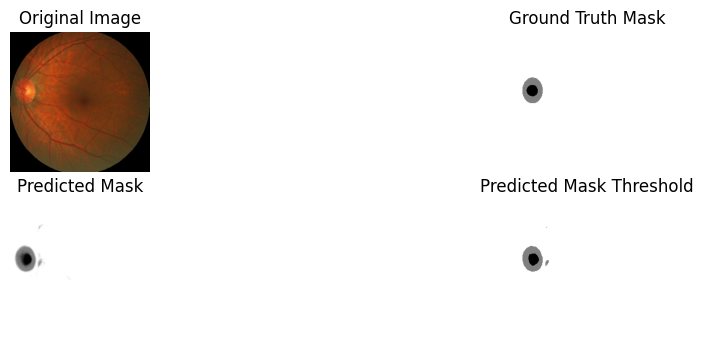

In [11]:
# 50, 50
image = images[0]  # Original test image
true_mask = masks[0]  # Ground truth mask
pred_mask = results[0]  # Predicted mask
pred_mask_binary = results_discrete[0]
# pred_mask = model.predict(np.expand_dims(image, axis=0))  # Predict mask
# pred_mask_binary = (pred_mask > 0.7).astype(int)  # Convert to binary

# Function to visualize image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Ground truth mask
plt.subplot(2, 2, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 4)
plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
plt.title("Predicted Mask Threshold")
plt.axis('off')
plt.show()

AUC-ROC Score (Level 1): 0.9259058512120147
AUC-ROC Score (Level 2): 0.9740125487766589


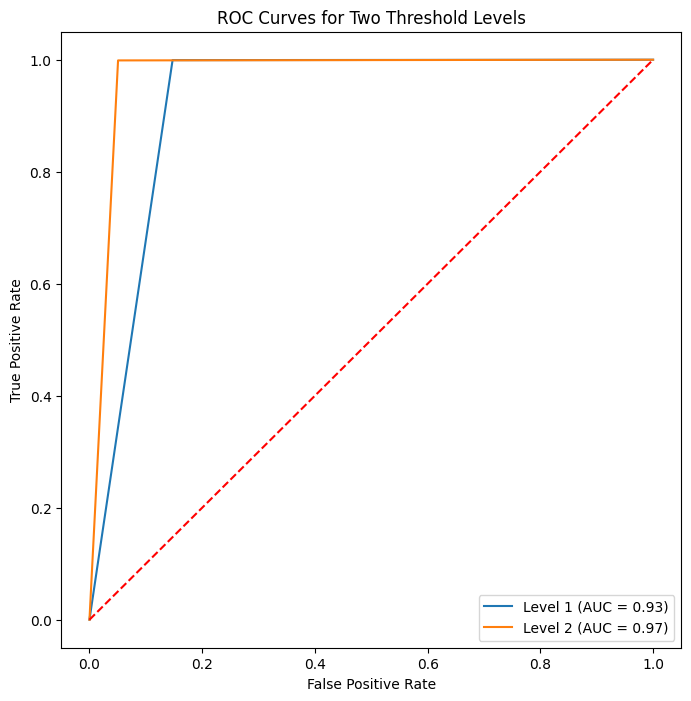

In [12]:
# Convert 3 discrete levels into two binary comparisons
# Level 1: Compare 0 vs (0.5 and 1)
y_true_level1 = (masks > 0).astype(int).flatten()  # 0 -> 0, (0.5 and 1) -> 1
y_pred_level1 = (results_discrete > 0.25).astype(int).flatten()

# Level 2: Compare 1 vs (0 and 0.5)
y_true_level2 = (masks == 1).astype(int).flatten()  # 1 -> 1, (0 and 0.5) -> 0
y_pred_level2 = (results_discrete > 0.75).astype(int).flatten()

# Calculate AUC for Level 1
auc_score_level1 = roc_auc_score(y_true_level1, y_pred_level1)
print("AUC-ROC Score (Level 1):", auc_score_level1)

# Calculate AUC for Level 2
auc_score_level2 = roc_auc_score(y_true_level2, y_pred_level2)
print("AUC-ROC Score (Level 2):", auc_score_level2)

# Plot ROC curves for both levels
fpr1, tpr1, _ = roc_curve(y_true_level1, y_pred_level1)
fpr2, tpr2, _ = roc_curve(y_true_level2, y_pred_level2)

plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1, label=f"Level 1 (AUC = {auc_score_level1:.2f})")
plt.plot(fpr2, tpr2, label=f"Level 2 (AUC = {auc_score_level2:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Two Threshold Levels")
plt.legend()
plt.show()

In [13]:
# compute accuracy
accuracy = accuracy_score(y_true_level1, y_pred_level1)
print("Accuracy:", accuracy)

# level 2
accuracy = accuracy_score(y_true_level2, y_pred_level2)
print("Accuracy:", accuracy)

Accuracy: 0.998634770711263
Accuracy: 0.9979553985595703


In [14]:
(0.9259+0.9740)/2

0.94995

In [15]:
(0.9986+0.99795)/2

0.998275

## Test on DRISHTI

In [16]:
# Main function to load data from train and test directories
def load_dataset_drishti(train_dir, test_dir, image_size):
    all_images = []
    all_masks = []
    
    train_img_dir = os.path.join(train_dir, 'Images')
    train_mask_dir = os.path.join(train_dir, 'GT')
    
    test_img_dir = os.path.join(test_dir, 'Images')
    test_mask_dir = os.path.join(test_dir, 'Test_GT')
    
    for basename in tqdm(os.listdir(train_mask_dir)):
        if not os.path.isdir(os.path.join(train_mask_dir, basename)):
            continue
        
        img_path = train_img_dir + '/GLAUCOMA/' + basename + '.png'
        if not os.path.exists(img_path):
            img_path = train_img_dir + '/NORMAL/' + basename + '.png'
        img = load_img(img_path, target_size=image_size)
        
        mask_path = train_mask_dir + '/' + basename + '/SoftMap/' + f'{basename}_cupsegSoftmap.png'
        mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
        
        img_array = img_to_array(img) / 255.0
        mask_array = (255 - img_to_array(mask)) / 255.0
        
        all_images.append(img_array)
        all_masks.append(mask_array)

    for basename in tqdm(os.listdir(test_mask_dir)):
        if not os.path.isdir(os.path.join(train_mask_dir, basename)):
            continue
        img_path = test_img_dir + '/glaucoma/' + basename + '.png'
        if not os.path.exists(img_path):
            img_path = test_img_dir + '/normal/' + basename + '.png'
        img = load_img(img_path, target_size=image_size)
        
        mask_path = test_mask_dir + '/' + basename + '/SoftMap/' + f'{basename}_cupsegSoftmap.png'
        mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
        mask = mask.point(lambda p: p > 128 and 255)
        
        img_array = img_to_array(img) / 255.0
        mask_array = (255 - img_to_array(mask)) / 255.0
        
        all_images.append(img_array)
        all_masks.append(mask_array)
        
    return np.array(all_images), np.array(all_masks)

In [17]:
train_dir = 'path/to/drishti_GS/Training-20211018T055246Z-001/Training'
test_dir = 'path/to/drishti_GS/Test-20211018T060000Z-001/Test'
image_size = (256, 256)

images, masks = load_dataset_drishti(train_dir, test_dir, image_size)

100%|██████████| 51/51 [00:00<00:00, 62601.55it/s]


In [18]:
results = model.predict(images)

2/2 [==============================] - 2s 700ms/step


In [19]:
results_discrete = np.zeros_like(results)  # Initialize with zeros
results_discrete[(results >= 0.25) & (results < 0.75)] = 0.5  # Set to 0.5 where within range
results_discrete[results >= 0.75] = 1

In [20]:
ious = []
dices = []

# Loop over the test set
for i in range(len(images)):
    true_mask = masks[i]  # Ground truth mask
    pred_mask = results_discrete[i]  # Predicted mask
    # pred_mask = results[i]
    
    # Calculate IoU and Dice for the current image
    iou = iou_metric(true_mask, pred_mask)
    dice = dice_coefficient(true_mask, pred_mask)
    
    ious.append(iou)
    dices.append(dice)

# Compute the average IoU and Dice over the entire test set
average_iou = np.mean(ious)
average_dice = np.mean(dices)

print(f"Average IoU on test set: {average_iou}")
print(f"Average Dice Coefficient on test set: {average_dice}")

Average IoU on test set: 0.9836810594659678
Average Dice Coefficient on test set: 0.9917666976374562


In [21]:
y_true_level1 = (masks > 0).astype(int).flatten()  # 0 -> 0, (0.5 and 1) -> 1
y_pred_level1 = (results_discrete > 0.25).astype(int).flatten()

# Level 2: Compare 1 vs (0 and 0.5)
y_true_level2 = (masks == 1).astype(int).flatten()  # 1 -> 1, (0 and 0.5) -> 0
y_pred_level2 = (results_discrete > 0.75).astype(int).flatten()

# IoU and Dice for Level 1
iou_level1 = iou_metric(y_true_level1, y_pred_level1)
dice_level1 = dice_coefficient(y_true_level1, y_pred_level1)

# IoU and Dice for Level 2
iou_level2 = iou_metric(y_true_level2, y_pred_level2)
dice_level2 = dice_coefficient(y_true_level2, y_pred_level2)

print(f"IoU for Level 1: {iou_level1}")
print(f"Dice Coefficient for Level 1: {dice_level1}")
print(f"IoU for Level 2: {iou_level2}")
print(f"Dice Coefficient for Level 2: {dice_level2}")

IoU for Level 1: 0.9927765267516295
Dice Coefficient for Level 1: 0.9963751714497836
IoU for Level 2: 0.9866594909793048
Dice Coefficient for Level 2: 0.9932849544266295


In [22]:
# mAP
precisions = []
recalls = []

# Loop over the test set
for i in range(len(images)):
    true_mask = masks[i]  # Ground truth mask
    pred_mask = results_discrete[i]  # Predicted mask
    # pred_mask = results[i]
    
    # Calculate precision and recall for the current image
    precision, recall = mAP_metric(true_mask, pred_mask)
    
    precisions.append(precision)
    recalls.append(recall)

# Compute the average precision and recall over the entire test set
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)

print(f"Average Precision on test set: {average_precision}")
print(f"Average Recall on test set: {average_recall}")

Average Precision on test set: 0.9974733850162224
Average Recall on test set: 0.9861464141242391


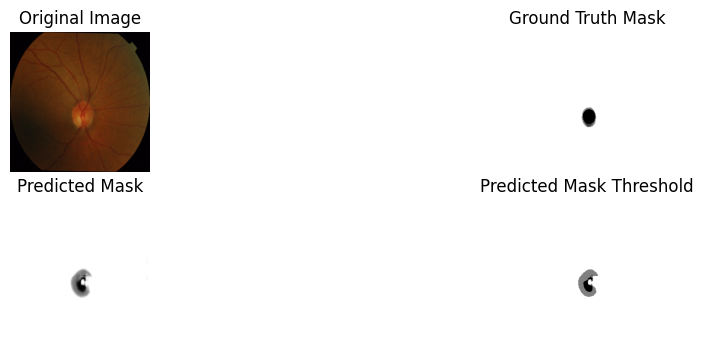

In [23]:
# 50, 50
image = images[10]  # Original test image
true_mask = masks[10]  # Ground truth mask
pred_mask = results[10]  # Predicted mask
pred_mask_binary = results_discrete[10]
# pred_mask = model.predict(np.expand_dims(image, axis=0))  # Predict mask
# pred_mask_binary = (pred_mask > 0.7).astype(int)  # Convert to binary

# Function to visualize image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Ground truth mask
plt.subplot(2, 2, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 4)
plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
plt.title("Predicted Mask Threshold")
plt.axis('off')
plt.show()

AUC-ROC Score (Level 1): 0.7444154433317428
AUC-ROC Score (Level 2): 0.9208747166205304


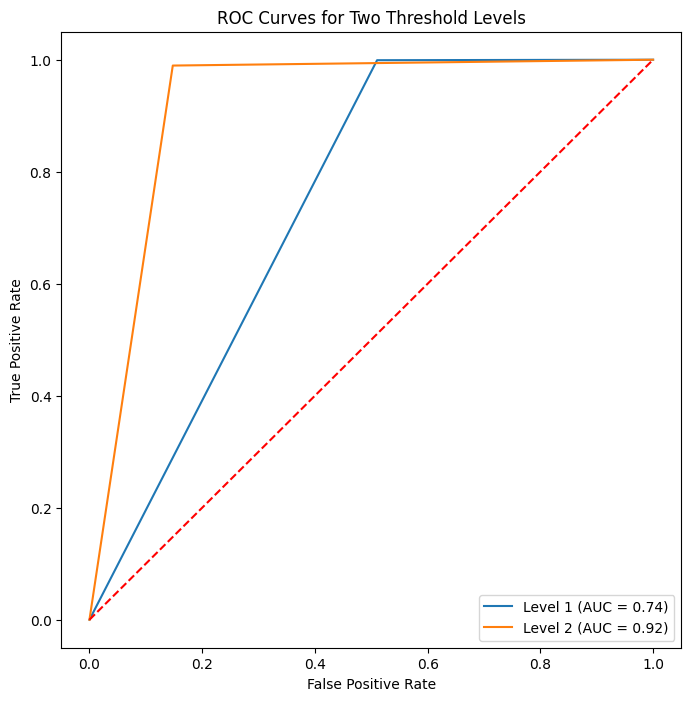

In [24]:
# Convert 3 discrete levels into two binary comparisons
# Level 1: Compare 0 vs (0.5 and 1)
y_true_level1 = (masks > 0).astype(int).flatten()  # 0 -> 0, (0.5 and 1) -> 1
y_pred_level1 = (results_discrete > 0.25).astype(int).flatten()

# Level 2: Compare 1 vs (0 and 0.5)
y_true_level2 = (masks == 1).astype(int).flatten()  # 1 -> 1, (0 and 0.5) -> 0
y_pred_level2 = (results_discrete > 0.75).astype(int).flatten()

# Calculate AUC for Level 1
auc_score_level1 = roc_auc_score(y_true_level1, y_pred_level1)
print("AUC-ROC Score (Level 1):", auc_score_level1)

# Calculate AUC for Level 2
auc_score_level2 = roc_auc_score(y_true_level2, y_pred_level2)
print("AUC-ROC Score (Level 2):", auc_score_level2)

# Plot ROC curves for both levels
fpr1, tpr1, _ = roc_curve(y_true_level1, y_pred_level1)
fpr2, tpr2, _ = roc_curve(y_true_level2, y_pred_level2)

plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1, label=f"Level 1 (AUC = {auc_score_level1:.2f})")
plt.plot(fpr2, tpr2, label=f"Level 2 (AUC = {auc_score_level2:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Two Threshold Levels")
plt.legend()
plt.show()

In [25]:
(0.744+0.9208)/2

0.8324

In [26]:
# compute accuracy
accuracy = accuracy_score(y_true_level1, y_pred_level1)
print("Accuracy:", accuracy)

# level 2
accuracy = accuracy_score(y_true_level2, y_pred_level2)
print("Accuracy:", accuracy)

Accuracy: 0.9928204345703125
Accuracy: 0.9868826293945312


In [27]:
(0.9928+0.9868)/2

0.9898